## Alternating Least Squares (ALS)

In [1]:
'''
Implements Alternating Least Squares (ALS) to create a recommender system for a subset of the Netflix dataset.
'''
import matplotlib.pyplot as plt
import numpy as np
import argparse
from scipy.sparse import csc_array, csr_array, csc_matrix, csr_matrix
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import ray
from random import shuffle


from more_itertools import chunked

In [2]:
ray_cores = 8
ray.init(num_cpus=ray_cores, ignore_reinit_error=True)

RayContext(dashboard_url='', python_version='3.9.13', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-11-22_18-09-11_255231_75517/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-11-22_18-09-11_255231_75517/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-11-22_18-09-11_255231_75517', 'metrics_export_port': 64954, 'gcs_address': '127.0.0.1:64705', 'address': '127.0.0.1:64705', 'node_id': '908e3374a29dda286c76b462efe73f65ee58d056bbef1d67665b448b'})

In [3]:
# file, out_dir, n_features = '../datasets/netflix/ratings.csv.gz', '../datasets/netflix/mf/', 300
# file, out_dir, n_features = '../datasets/movie_lens/ratings.csv.gz', '../datasets/movie_lens/mf/', 200
file, out_dir, n_features = '../datasets/kgrec/music_ratings.csv.gz', '../datasets/kgrec/mf/', 50
# file, out_dir, n_features = '../datasets/spotify/ratings.csv.gz', '../datasets/spotify/mf/', 300
original_data = pd.read_csv(file)

print(original_data.head())
# chceck ids
assert original_data['user_id'].nunique() == original_data['user_id'].max() + 1
assert original_data['item_id'].nunique() == original_data['item_id'].max() + 1

   user_id  item_id
0        0        0
1        0        1
2        0        2
3        0        3
4        0        4


In [4]:
# keep only users with at least n ratings
n = 10
num_ratings = original_data.groupby('user_id').size()
index_size_ok = num_ratings[num_ratings >= n].index
index_size_low = num_ratings[num_ratings < n].index
original_data_ok = original_data[original_data['user_id'].isin(index_size_ok)]
original_data_low = original_data[original_data['user_id'].isin(index_size_low)]

In [5]:
def load_and_process_df(file):
    '''
    Loads a dataframe from a file and returns a sparse matricies.
    '''
    # df = pd.read_csv(file)
    df = original_data_ok.copy()
    df_low = original_data_low.copy()

    if 'user_id' not in df.columns or 'item_id' not in df.columns:
        raise Exception('Dataframe does not have user_id and item_id columns')
    if not 'rating' in df.columns:
        df['rating'] = 1
        df_low['rating'] = 1
    
    df = df[['user_id', 'item_id', 'rating']]
    df_low = df_low[['user_id', 'item_id', 'rating']]


    # split to training and testing data 80:20 for each user
    training, testing = train_test_split(df, test_size=0.2, stratify=df['user_id'])
    # training = pd.concat([training, df_low])

    num_of_users = df['user_id'].max() + 1
    num_of_items = df['item_id'].max() + 1

    training_data_csc = csc_matrix((training['rating'], (training['user_id'], training['item_id'])), shape=(num_of_users, num_of_items))
    training_data_t_csc = csc_matrix((training['rating'], (training['item_id'], training['user_id'])), shape=(num_of_items, num_of_users))
    testing_data_csc = csc_matrix((testing['rating'], (testing['user_id'], testing['item_id'])), shape=(num_of_users, num_of_items))
    
    # check if the last value is only in training data xor testing data
    # print(training_data)
    uid = int(df.iloc[-1]['user_id'])
    iid = int(df.iloc[-1]['item_id'])
    rating = df.iloc[-1].rating
    in_train = training_data_csc[uid, iid] == rating
    in_test = testing_data_csc[df.iloc[-1]['user_id'], df.iloc[-1]['item_id']] == df.iloc[-1].rating
    assert (in_train and not in_test) or (not in_train and in_test), 'Dataframe is not split correctly'
    
    return training_data_csc, training_data_t_csc, testing_data_csc


training_data_csc, training_data_t_csc, testing_data_csc = load_and_process_df('../datasets/netflix/ratings.csv.gz')
# training_data_t = training_data.T
# testing_data_t = testing_data.T

print(training_data_csc.shape)
print(testing_data_csc.shape)
print(training_data_t_csc.shape)
# print(testing_data_t.shape)

(5199, 8640)
(5199, 8640)
(8640, 5199)


In [15]:
# @ray.remote
def process_single_index_ray(j, l2_lambda, data_ray, fixed_matrix_ray):
    nonzeros = data_ray[:,j].nonzero()[0]
    y = data_ray[nonzeros, j].todense()
    X = fixed_matrix_ray[:, nonzeros]
    return np.squeeze(np.linalg.inv(X.dot(X.T) + l2_lambda * np.eye(X.shape[0])).dot(X.dot(y)))

def cf_ridge_regression_column_wise(target_matrix, fixed_matrix, data_ray, l2_lambda):
    '''
    Solves a ridge regression problem using a closed form solution:
        w_i = (X'X + lambda * I)^-1 X'y
    for all i in the target matrix.
    '''
    # fixed_matrix_ray = ray.put(fixed_matrix)
    fixed_matrix_ray = fixed_matrix
    matrix_column_indexes = list(range(target_matrix.shape[1]))
    shuffle(matrix_column_indexes)

    with tqdm(total=target_matrix.shape[1]) as pbar:
        for chunk_j in chunked(matrix_column_indexes, n=100):
            # futures = []
            results = []
            for j in chunk_j:
                result = process_single_index_ray(j, l2_lambda, data_ray, fixed_matrix_ray)
                results.append(result)
                # futures.append(process_single_index_ray.remote(j, l2_lambda, data_ray, fixed_matrix_ray))
            # results = ray.get(futures)
            for j, result in zip(chunk_j, results):
                target_matrix[:,j] = result
            pbar.update(len(chunk_j))
    
    del fixed_matrix_ray


def sum_squared_error(gt_data, U, M):
    U_small = U[:,0:1000].T
    M_small = M[:,0:1000]
    resulting = U_small.dot(M_small)
    gt_data_subset = gt_data[0:1000,0:1000]
    diff = gt_data_subset - resulting
    error = diff[gt_data_subset[0:1000,0:1000].nonzero()]
    error2 = (np.array(error) ** 2).sum()
    return error2
    # return (np.array((training_data[0:1000,0:1000] - U[0:1000,:].T.dot(M[0:1000,:]))[training_data[0:1000,0:1000].nonzero()]) ** 2).sum()

# Initialize the parameters
total_ratings = 100_000

converge = 1e-6

max_steps = 5
l2_lambda = 10
delta = converge + 1.
cur_error = 1.
cur_step = 0

verbose = True

random_start, random_end = 0, 1
U_features = np.random.uniform(random_start, random_end, size=(n_features, training_data_csc.shape[0]))
I_features = np.random.uniform(random_start, random_end, size=(n_features, training_data_csc.shape[1]))

# U_features = np.ones((n_features, training_data_csc.shape[0])) # features x users
# I_features = np.ones((n_features, training_data_csc.shape[1])) # features x items

training_trace = []
testing_trace = []

train_error = sum_squared_error(training_data_csc, U_features, I_features)
test_error = sum_squared_error(testing_data_csc, U_features, I_features)
training_trace.append(np.sqrt(train_error / total_ratings))
testing_trace.append(np.sqrt(test_error / total_ratings))

print('Training error: {0}'.format(np.sqrt(train_error / total_ratings)))
print('Testing error: {0}'.format(np.sqrt(test_error / total_ratings)))


while delta > converge and cur_step < max_steps:
    print('Step #{0}'.format(cur_step))

    # Use the closed-form solution for the ridge-regression subproblems
    # training_data_csc_ray = ray.put(training_data_csc)
    # training_data_t_csc_ray = ray.put(training_data_t_csc)
    training_data_csc_ray = training_data_csc
    training_data_t_csc_ray = training_data_t_csc
    # slice_size = 50
    print('Fitting M')
    # cf_ridge_regression_column_wise_m(target_matrix=I_features, fixed_matrix=U_features, data_ray=training_data_csc_ray, l2_lambda=l2_lambda, slice_size=slice_size)
    cf_ridge_regression_column_wise(target_matrix=I_features, fixed_matrix=U_features, data_ray=training_data_csc_ray, l2_lambda=l2_lambda)
    print('Fitting U')
    # cf_ridge_regression_column_wise_m(target_matrix=U_features, fixed_matrix=I_features, data_ray=training_data_t_csc_ray, l2_lambda=l2_lambda, slice_size=slice_size)
    cf_ridge_regression_column_wise(target_matrix=U_features, fixed_matrix=I_features, data_ray=training_data_t_csc_ray, l2_lambda=l2_lambda)

    # Track performance in terms of RMSE on both the testing and training sets
    train_error = sum_squared_error(training_data_csc, U_features, I_features)
    test_error = sum_squared_error(testing_data_csc, U_features, I_features)
    training_trace.append(np.sqrt(train_error / total_ratings))
    testing_trace.append(np.sqrt(test_error / total_ratings))

    # Track convergence
    prev_error = cur_error
    cur_error = train_error
    delta = np.abs(prev_error - cur_error) / (prev_error + converge)
    print('Training error: {0}'.format(np.sqrt(train_error / total_ratings)))
    print('Testing error: {0}'.format(np.sqrt(test_error / total_ratings)))
    print('Delta: {0}'.format(delta))
    # Update the step counter
    cur_step += 1



Training error: 7.50069199075247
Testing error: 3.7357203869788167
Step #0
Fitting M


100%|██████████| 8640/8640 [04:46<00:00, 30.15it/s]  


Fitting U


100%|██████████| 5199/5199 [00:06<00:00, 785.84it/s]


Training error: 0.3435115494132952
Testing error: 0.17150727282279143
Delta: 11799.00665902562
Step #1
Fitting M


100%|██████████| 8640/8640 [00:08<00:00, 1019.41it/s]


Fitting U


100%|██████████| 5199/5199 [00:04<00:00, 1078.99it/s]


Training error: 0.14351140139584168
Testing error: 0.07169537059799458
Delta: 0.8254619481138723
Step #2
Fitting M


100%|██████████| 8640/8640 [00:08<00:00, 982.26it/s] 


Fitting U


100%|██████████| 5199/5199 [00:06<00:00, 862.62it/s]


Training error: 0.10051874774730954
Testing error: 0.05024060594543619
Delta: 0.5094070210217511
Step #3
Fitting M


100%|██████████| 8640/8640 [00:09<00:00, 946.36it/s] 


Fitting U


100%|██████████| 5199/5199 [00:05<00:00, 1038.46it/s]


Training error: 0.07993803413405222
Testing error: 0.040008966543976156
Delta: 0.36756952584179775
Step #4
Fitting M


100%|██████████| 8640/8640 [00:09<00:00, 891.98it/s] 


Fitting U


100%|██████████| 5199/5199 [00:04<00:00, 1078.19it/s]

Training error: 0.0687660300353542
Testing error: 0.03448003841206977
Delta: 0.2599842245518299


In [16]:
# save features
#create output directory
from pathlib import Path


Path.mkdir(Path(out_dir), exist_ok=True)

np.save(out_dir + 'U_features.npy', U_features)
np.save(out_dir + 'I_features.npy', I_features)

# print statistics about features
print('U_features shape: {0}'.format(U_features.shape))
print('I_features shape: {0}'.format(I_features.shape))
print(U_features)
print(I_features)

U_features shape: (50, 5199)
I_features shape: (50, 8640)
[[0.13784807 0.14868145 0.14918857 ... 0.14038778 0.16212827 0.15503662]
 [0.13623781 0.14677962 0.14749793 ... 0.13853498 0.16059816 0.15355152]
 [0.15148272 0.16364849 0.16371885 ... 0.15451124 0.17619324 0.16896742]
 ...
 [0.13509931 0.14575816 0.14624011 ... 0.13730569 0.1582999  0.15191237]
 [0.12622035 0.13595991 0.13678895 ... 0.12803642 0.14988692 0.14328426]
 [0.13121162 0.14136184 0.14224296 ... 0.13358856 0.15545185 0.14837814]]
[[0.11216644 0.10273266 0.11021925 ... 0.06423135 0.05260757 0.06421279]
 [0.11074363 0.10167187 0.10882213 ... 0.06363733 0.05192382 0.06355258]
 [0.12356001 0.11238594 0.12144639 ... 0.06974514 0.05784752 0.07028491]
 ...
 [0.11006925 0.10069657 0.1082094  ... 0.0627203  0.05141562 0.06283538]
 [0.10262926 0.0947887  0.10091145 ... 0.05961154 0.04814565 0.05923833]
 [0.10645592 0.09786547 0.10452123 ... 0.06144014 0.0499325  0.06104448]]


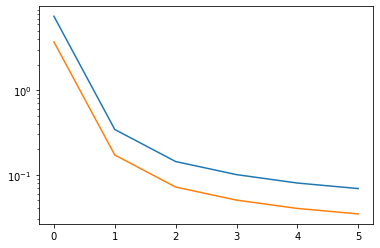

In [17]:

plt.figure()
plt.plot(np.arange(cur_step + 1), np.array(training_trace), label='Training RMSE')
plt.plot(np.arange(cur_step + 1), np.array(testing_trace), label='Testing RMSE')
plt.yscale('log')
# plt.savefig(args.plot_results, bbox_inches='tight')
plt.show()

In [47]:
user_idx = 5001
predicted_ratings = U_features[:,user_idx].T.dot(I_features)
print(predicted_ratings.shape)
print(predicted_ratings)

(8640,)
[0.90776632 0.83007527 0.89232732 ... 0.51707753 0.42463358 0.51831085]


In [48]:
# non_zero_training_data = training_data_csc[user_idx, :].nonzero()
training_data_for_user = training_data_csc[user_idx, :].nonzero()[1]
training_data_for_user
# print('non_zero_training_data: {0}'.format(non_zero_training_data))
Ufeatures_for_user = U_features[:, user_idx]
print(Ufeatures_for_user.shape)



# items_pref_to_user = 
# print(training_data_csc[5000, :])

(50,)


In [52]:
predicted_ratings[1000:1050]

array([0.8207405 , 0.91436305, 0.90653959, 0.93076408, 0.8826221 ,
       0.92238382, 0.81242267, 0.67241308, 0.87714618, 0.79395072,
       0.9034721 , 0.91654259, 0.87261714, 0.60069379, 0.8929872 ,
       0.8972871 , 0.90251166, 0.92652384, 0.89162601, 0.91271591,
       0.92805969, 0.88696621, 0.79376183, 0.89421271, 0.88007687,
       0.9406325 , 0.91704071, 0.9044102 , 0.81160155, 0.75578747,
       0.90818315, 0.89835879, 0.93459288, 0.90586487, 0.92316293,
       0.83006045, 0.81109218, 0.89660071, 0.89980016, 0.77127074,
       0.91911306, 0.88220677, 0.88562136, 0.9183745 , 0.89056182,
       0.81577595, 0.71667857, 0.80216292, 0.91574745, 0.59839985])

In [33]:
res = U_features[:, 0].dot(I_features)[0:100]
print(res.shape)
print(res)

(100,)
[0.83776353 0.76542611 0.82423075 0.8777731  0.6096057  0.8278212
 0.86623051 0.67675107 0.81795149 0.74677404 0.86918123 0.86777417
 0.80698795 0.83803672 0.84482025 0.7819067  0.8537904  0.87429336
 0.87269991 0.49960002 0.87031027 0.84889768 0.86868637 0.86643409
 0.82168259 0.80939207 0.83549377 0.81437082 0.86326641 0.84834858
 0.83443949 0.83726091 0.63925272 0.4545587  0.85420796 0.86039804
 0.7069584  0.86316091 0.82743435 0.73769237 0.78908918 0.8624932
 0.84795625 0.65731595 0.86179821 0.74990371 0.72385688 0.87195536
 0.84099866 0.82416679 0.86695704 0.85754652 0.87276578 0.8179922
 0.81912993 0.81037582 0.87019665 0.82861194 0.74111313 0.84743921
 0.86529125 0.72533676 0.81622213 0.84847125 0.8582184  0.55814753
 0.82641946 0.85951714 0.80843467 0.84592733 0.67802317 0.83523269
 0.86418801 0.86359249 0.85116655 0.86919565 0.8257108  0.86240129
 0.85954126 0.82294071 0.87010557 0.69349592 0.61001121 0.83096176
 0.86473799 0.82286874 0.83322787 0.86689    0.79300435 0.